<div style="background-image:url(instaseis_images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px; background-position: 0px -200px">
<p style="float:right; margin-top:20px; padding: 20px 60px 0px 10px; background:rgba(255,255,255,0.75); border-radius:10px;">
<img width="400px" src=instaseis_images/logo.png>
</p>

<h1 style="color:#BBB; padding-bottom: 10px">Instaseis Tutorial</h1>
<h2 style="color:#BBB; padding-bottom: 60px">Part 4: Finite Sources</h2>

</div>

## Advanced Exercise 2: Finite Source Effects

For earthquakes with Magnitude up to about 5 recorded at teleseismic distances, approximating the fault by a point source is a reasonable approach. However, for larger earthquakes with longer rupture duration this approximation is not valid anymore. In this exercise, you will compare the point source approximation with finite source solutions to understand its limitations.

For three of the earthquakes we use in this tutorial, USGS provides finite fault solutions: 
the recent event in [Nepal](http://earthquake.usgs.gov/earthquakes/eventpage/us20002926#scientific_finitefault),
the largest [aftershock](http://earthquake.usgs.gov/earthquakes/eventpage/us20002ejl#scientific_finitefault)
and the one in [Chile](http://earthquake.usgs.gov/earthquakes/eventpage/usc000nzvd#scientific_finitefault). This is the fault solution and slip as a function of time for the Nepal M7.9 event:

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;"><img src="instaseis_images/finite_source_fault.png" style="width: 100%">Fault representation (image: USGS)</p><p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;"><img src="instaseis_images/finite_source_stf.png" style="width: 100%">Source Time Function (image: USGS)</p><p style="clear: both;">

-----

Basic lines to set up the notebook and some paths.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import obspy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)

Import Instaseis and open the database:

In [2]:
import instaseis
db = instaseis.open_db("data/database")

-----

In Instaseis, a finite fault is represented as set of point sources, where each point source represents one of the fault patches with individual source time function. This functionality is provided by the `instaseis.FiniteSource` object [(see Documentation)](http://instaseis.net/source.html#instaseis.source.FiniteSource). It can be initialized in two ways: from a list of point sources, or more conveniently by reading \*.param files provided by USGS or standard rupture format (\*.srf) files (these can also be used in the GUI).

In [3]:
finite_source = instaseis.FiniteSource.from_usgs_param_file(
    'data/events/finite_source/FINITE_SOURCE_2015_05_12__Mw_7_2_Nepal.param')
print(finite_source)

Instaseis Finite Source:
	Moment Magnitude     : 7.34
	scalar Moment        :   1.04e+20 Nm
	#point sources       : 525
	rupture duration     :   35.8 s
	time shift           :    0.0 s
	min depth            : 8695.7 m
	max depth            : 20897.6 m
	hypocenter depth     : 20897.6 m
	min latitude         :   27.1 deg
	max latitude         :   28.3 deg
	hypocenter latitude  :   27.7 deg
	min longitude        :   85.4 deg
	max longitude        :   86.9 deg
	hypocenter longitude :   86.2 deg



A point source can be computed as a sum of all point sources weighted by their moment:

In [4]:
finite_source.compute_centroid()
print(finite_source.CMT)

Instaseis Source:
	origin time      : 1970-01-01T00:00:00.000000Z
	Longitude        :   86.2 deg
	Latitude         :   27.7 deg
	Depth            : 1.5e+01 km
	Moment Magnitude :   7.33
	Scalar Moment    :   9.76e+19 Nm
	Mrr              :   2.63e+19 Nm
	Mtt              :  -2.46e+19 Nm
	Mpp              :  -1.70e+18 Nm
	Mrt              :   9.33e+19 Nm
	Mrp              :  -8.13e+18 Nm
	Mtp              :   9.86e+18 Nm



The hypo- and epicenter can be found as the fault patch that ruptures first:

In [5]:
finite_source.find_hypocenter()
print('hypocenter latitude:', finite_source.hypocenter_latitude,
      'longitude:', finite_source.hypocenter_longitude,
      'depth:', finite_source.hypocenter_depth_in_m / 1e3)

hypocenter latitude: 27.6644420818 longitude: 86.1627 depth: 14.7966


**Task:** Compare the seismograms for three different representations of the source: 

* A point source with simple gaussian source time function (using CMTSOLUTION or quakeml files),
* the CMT solution using the more complex source time function provided by `finite_source.CMT`
* the full finite source solution using the `FiniteSource` object and `db.get_seismograms_finite_source()`

**Note:** First, you have to adapt the sampling of the source time functions in the finite source to the database, which works like this:

In [6]:
# reloading finite source here to be sure to have a clean source time function
finite_source = instaseis.FiniteSource.from_usgs_param_file(
    'data/events/finite_source/FINITE_SOURCE_2015_05_12__Mw_7_2_Nepal.param')

# prepare the source time functions to be at the same sampling as the database
# first use enough samples such that the lowpassed stf will still be correctly represented
nsamp = int(db.info.period / finite_source[0].dt) * 50
finite_source.resample_sliprate(dt=finite_source[0].dt, nsamp=nsamp)
# lowpass to avoid aliasing
finite_source.lp_sliprate(freq=1.0/db.info.period)
# finally resample to the sampling as the database
finite_source.resample_sliprate(dt=db.info.dt, nsamp=db.info.npts)

finite_source.compute_centroid()

**Solution**

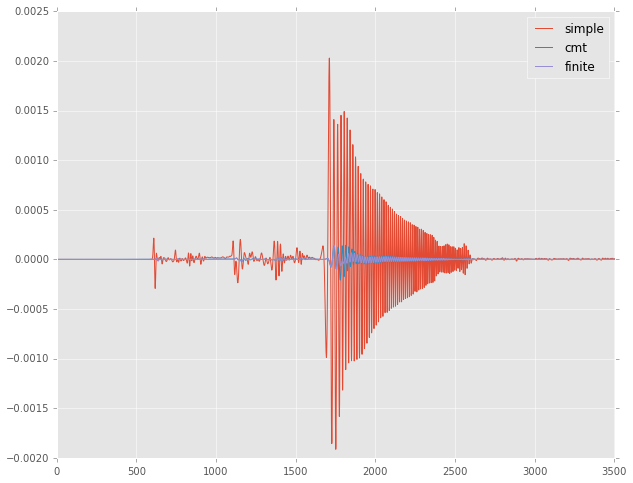

In [7]:
# load receivers from stations xml file
receivers = instaseis.Receiver.parse('data/stations/all_stations.xml')

simple_source = instaseis.Source.parse(
    'data/events/quakeml/GCMT_2015_04_25__Mw_7_9.xml')

# compute seismogram with CMT solution and no simple source time function (gaussian):
tr_simple = db.get_seismograms(
    simple_source, receivers[0], components=('Z'), dt=1.0)[0]

# compute seismogram with CMT solution and source time function computed as the 
# sum of all source time functions in the finite source (reconvolve_stf=True):
tr_cmt = db.get_seismograms(
    finite_source.CMT, receivers[0], components=('Z'),
    dt=1.0, reconvolve_stf=True, remove_source_shift=False)[0]

# compute seismogram for finite source
tr_finite = db.get_seismograms_finite_source(
    finite_source, receivers[0], components=('Z'), dt=1.0)[0]

plt.plot(tr_simple.times(), tr_simple.data, label='simple')
plt.plot(tr_cmt.times(), tr_cmt.data, label='cmt')
plt.plot(tr_finite.times(), tr_finite.data, label='finite')
 
plt.legend()
plt.xlim(0, tr_simple.times()[-1])

plt.show()

### Acknowledgements

Background picture at the very top is from Matthias Meschede.